In [1]:
import sys as _sys
import os

currentPath = os.path.abspath(os.getcwd())

split = currentPath.split("Cshells")
if len(split)<2:
    print("Please rename the repository 'Cshells'")
    raise ValueError
pathToPythonScripts = split[0] + "Cshells/python/"
pathToModels = os.path.join(split[0], "Cshells/data/models")
pathToOutputs = os.path.join(split[0], "Cshells/output")

_sys.path.insert(0, pathToPythonScripts)

In [26]:
import MeshFEM
import ElasticRods

import average_angle_linkages
from bending_validation import suppress_stdout as so
import elastic_rods
import math
import numpy as np
import pickle
import torch

from CShell import CShell
from CurvesDoFOptimizer import CurvesDoFOptimizer
from linkage_vis import LinkageViewer
from open_average_angle_linkage import ComputeStressesHistogram, open_average_angle_linkage, RunAndAnalyzeDeployment, PlotDeploymentQuantities
import py_newton_optimizer
from vis.fields import ScalarField
from VisUtils import ConvergencePlotsVisualizer, PlotStackedConvergencePlots
from VisUtilsDeployment import CompareDeploymentStatistics, CompareDeploymentQuantities

torch.set_default_dtype(torch.float64)
    
def ToNumpy(tensor):
    return tensor.cpu().detach().clone().numpy()

PI = math.pi

# Initialization

In [3]:
modelName = "torus_symmetric"

with open(os.path.join(pathToModels, modelName, "flat_optimized.p"), 'rb') as f:
    flatLinkage = pickle.load(f)
    
with open(os.path.join(pathToModels, modelName, "deployed_optimized.p"), 'rb') as f:
    depLinkage = pickle.load(f)
    
linkagesGuess = {
    "flat": flatLinkage,
    "deployed": depLinkage,
}

In [4]:
with open(os.path.join(pathToModels, modelName, "cshell_optimized.p"), 'rb') as f:
    dictCShell = pickle.load(f)
    
cshell = CShell(
    dictCShell["curvesDoF"], dictCShell["nJ"], dictCShell["curves"], dictCShell["curvesFamily"], dictCShell["nCPperRodEdge"], 
    dictCShell["alphaTar"].item(), dictCShell["mult"], dictCShell["subdivision"], symmetry=dictCShell["symmetry"],
    attractionMesh=dictCShell["attractionMesh"], targetMesh=dictCShell["targetMesh"],
    rodMaterial=dictCShell["flatLinkage"].homogenousMaterial(), optimizeAlpha=True, useSAL=True, 
    linkagesGuess=linkagesGuess, flatOnly=False,
)

0	0.000281661	4.88866e-10	4.88866e-10	0	0
0	9.67191	6.62517e-08	6.62517e-08	0	0
Instantiation will fail since knitro has not been found.
Knitro has not been found: cannot instantiate the linkage optimizer.


In [5]:
cshell.flatView.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [6]:
cshell.deployedView.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

# Different actuations

We show different actuation strategies for the same model and record some metric along the deployment paths. Note that `RunAndAnalyzeDeployment` creates a copy linkage and hence does not modify the input linkage. More details about how to recover the deployed linkage can be found in `python/open_average_angle_linkage.py`.

In [7]:
computeActuations = True
numOpeningSteps = 30
maxNewtonIterIntermediate = 500 # maximum number of equilibrium steps taken per opening step

## Deployment using the flat state

In [8]:
flatLinkDep = average_angle_linkages.AverageAngleLinkage(cshell.flatLinkage)
targetLinkDep = average_angle_linkages.AverageAngleLinkage(cshell.deployedLinkage)

viewerDep = LinkageViewer(flatLinkDep, width=768, height=480)
viewerDep.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [9]:
if computeActuations:
    initDeployment = RunAndAnalyzeDeployment(
        flatLinkDep, targetLinkDep, numOpeningSteps=numOpeningSteps,
        maxNewtonIterIntermediate=maxNewtonIterIntermediate, view=viewerDep
    )
    initStressHist = ComputeStressesHistogram(initDeployment["stresses"])
    PlotDeploymentQuantities(initDeployment, initStressHist)
    successes = [initDeployment['ConvergenceReports'][i].success for i in range(len(initDeployment['ConvergenceReports']))]
    gradNorms = [initDeployment['ConvergenceReports'][i].gradientNorm[-1] for i in range(len(initDeployment['ConvergenceReports']))]
    freeGradNorms = [initDeployment['ConvergenceReports'][i].freeGradientNorm[-1] for i in range(len(initDeployment['ConvergenceReports']))]
    print("Convergence success percentage {:.2f}%".format(100.0*np.mean(successes)))

NameError: name 'PlotDeploymentQuantities' is not defined

## Undeployment from the deployed state

In [14]:
flatLinkUndep = average_angle_linkages.AverageAngleLinkage(cshell.flatLinkage)
targetLinkUndep = average_angle_linkages.AverageAngleLinkage(cshell.deployedLinkage)

viewerUndep = LinkageViewer(targetLinkUndep, width=768, height=480)
viewerUndep.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

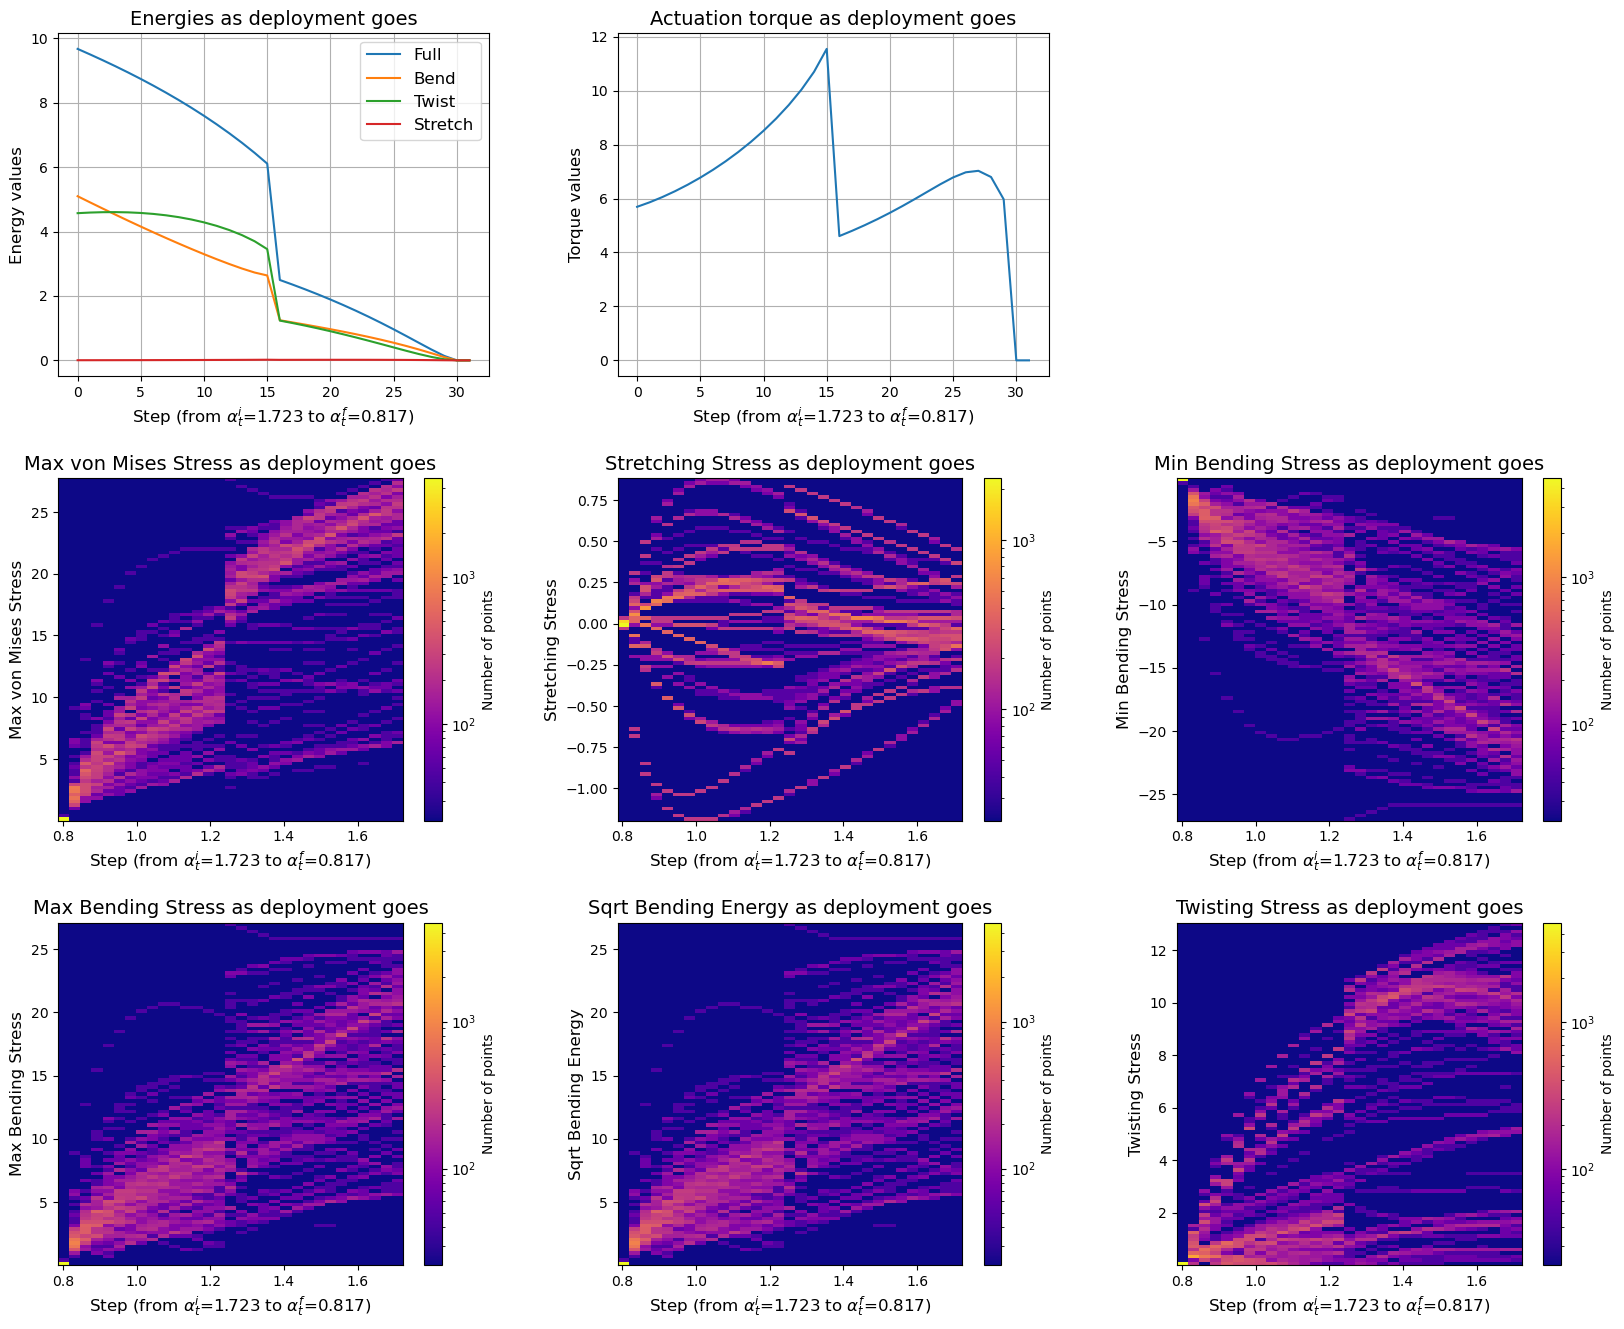

Convergence success percentage 100.00%


In [15]:
if computeActuations:
    unDeployment = RunAndAnalyzeDeployment(
        targetLinkUndep, flatLinkUndep, numOpeningSteps=numOpeningSteps,
        maxNewtonIterIntermediate=maxNewtonIterIntermediate, view=viewerUndep
    )
    undepStressHist = ComputeStressesHistogram(unDeployment["stresses"])
    PlotDeploymentQuantities(unDeployment, undepStressHist)
    undepSuccesses = [unDeployment['ConvergenceReports'][i].success for i in range(len(unDeployment['ConvergenceReports']))]
    undepGradNorms = [unDeployment['ConvergenceReports'][i].gradientNorm[-1] for i in range(len(unDeployment['ConvergenceReports']))]
    undepFreeGradNorms = [unDeployment['ConvergenceReports'][i].freeGradientNorm[-1] for i in range(len(unDeployment['ConvergenceReports']))]
    print("Convergence success percentage {:.2f}%".format(100.0*np.mean(undepSuccesses)))

## Table trick

To deploy our physical prototype into the intended shape, we used a table to constrain some joints. Hence the name table trick. In the code, we simply pin the z coordinate of valence 2 joints.

In [17]:
fixedHeights = []
for ji in range(cshell.nJ):
    if cshell.deployedLinkage.joint(ji).valence() == 2:
        fixedHeights.append(cshell.deployedLinkage.dofOffsetForJoint(ji) + 2)

flatLinkTT = average_angle_linkages.AverageAngleLinkage(cshell.flatLinkage)
targetLinkTT = average_angle_linkages.AverageAngleLinkage(cshell.deployedLinkage)

viewerTT = LinkageViewer(flatLinkTT, width=768, height=480)
viewerTT.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

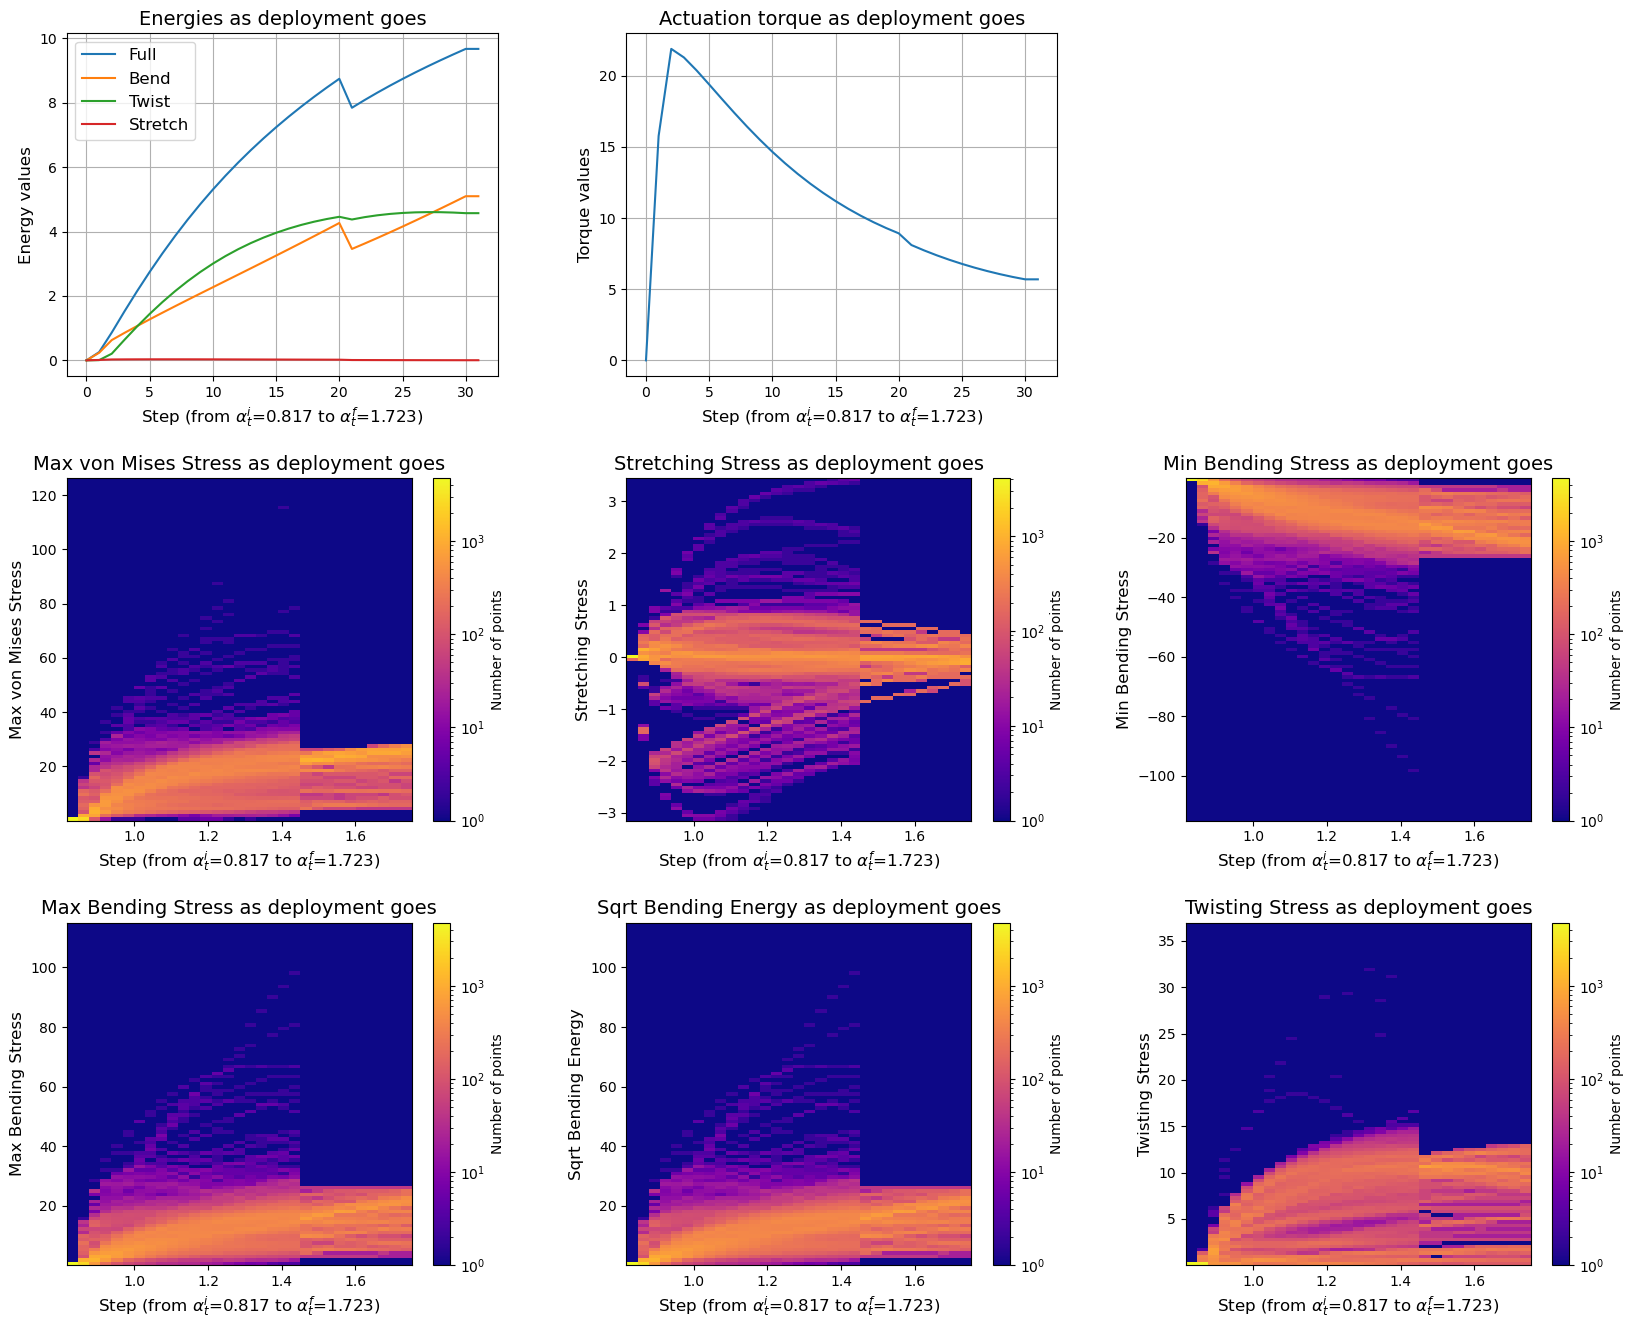

Convergence success percentage 100.00%


In [18]:
if computeActuations:
    tableTrick = RunAndAnalyzeDeployment(
        flatLinkTT, targetLinkTT, numOpeningSteps=numOpeningSteps, 
        maxNewtonIterIntermediate=maxNewtonIterIntermediate,
        additionalFixedVars=fixedHeights, releaseFixedVarsAngle=1.45,
        view=viewerTT,
    )
    ttStressHist = ComputeStressesHistogram(tableTrick["stresses"])
    PlotDeploymentQuantities(tableTrick, ttStressHist)
    ttSuccesses = [tableTrick['ConvergenceReports'][i].success for i in range(len(tableTrick['ConvergenceReports']))]
    ttGradNorms = [tableTrick['ConvergenceReports'][i].gradientNorm[-1] for i in range(len(tableTrick['ConvergenceReports']))]
    ttFreeGradNorms = [tableTrick['ConvergenceReports'][i].freeGradientNorm[-1] for i in range(len(tableTrick['ConvergenceReports']))]
    print("Convergence success percentage {:.2f}%".format(100.0*np.mean(ttSuccesses)))

## Saddle deployment

In [28]:
flatLinkSaddle = average_angle_linkages.AverageAngleLinkage(cshell.flatLinkage)
targetLinkSaddle = average_angle_linkages.AverageAngleLinkage(cshell.flatLinkage)

def equilibriumSolver(tgtAngle, l, opts, fv):
    opts.gradTol = 1.0e-5
    return average_angle_linkages.compute_equilibrium(l, tgtAngle, options=opts, fixedVars=fv)

numOpeningSteps = 10
maxNewtonIterIntermediate = 500
driver = targetLinkSaddle.centralJoint()

with so(): open_average_angle_linkage(
    targetLinkSaddle, driver, -0.20, 10, 
    None, equilibriumSolver=equilibriumSolver, 
    maxNewtonIterationsIntermediate=500
)

viewerSaddle = LinkageViewer(flatLinkSaddle, width=768, height=480)
viewerSaddle.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

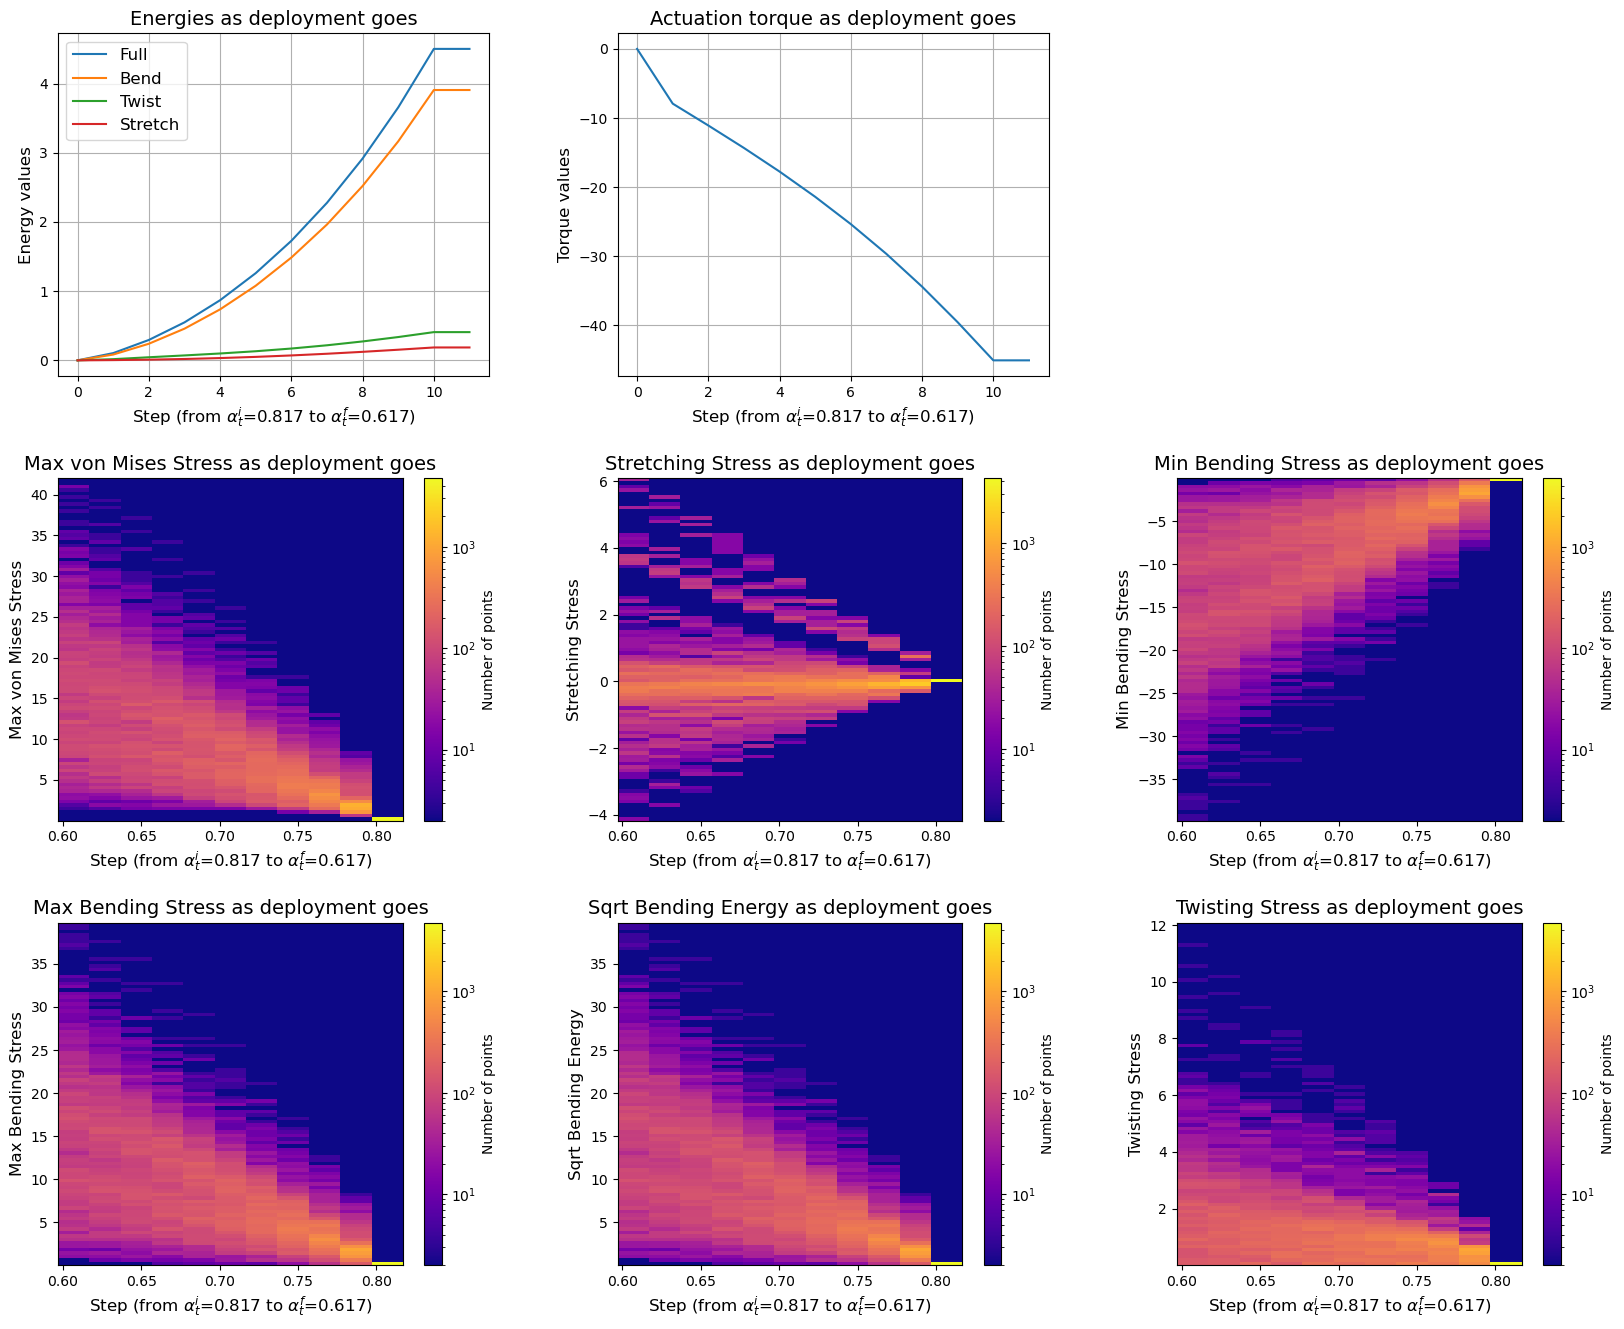

Convergence success percentage 90.91%


In [29]:
if computeActuations:
    saddleDeployment = RunAndAnalyzeDeployment(
        flatLinkSaddle, targetLinkSaddle, numOpeningSteps=numOpeningSteps, 
        maxNewtonIterIntermediate=maxNewtonIterIntermediate, view=viewerSaddle,
    )
    
    toSaddleStressHist    = ComputeStressesHistogram(saddleDeployment["stresses"])
    PlotDeploymentQuantities(saddleDeployment, toSaddleStressHist)
    toSaddleSuccesses     = [saddleDeployment['ConvergenceReports'][i].success for i in range(len(saddleDeployment['ConvergenceReports']))]
    toSaddleGradNorms     = [saddleDeployment['ConvergenceReports'][i].gradientNorm[-1] for i in range(len(saddleDeployment['ConvergenceReports']))]
    toSaddleFreeGradNorms = [saddleDeployment['ConvergenceReports'][i].freeGradientNorm[-1] for i in range(len(saddleDeployment['ConvergenceReports']))]
    print("Convergence success percentage {:.2f}%".format(100.0*np.mean(toSaddleSuccesses)))

# Save deployments

In [30]:
pathToSave = os.path.join(pathToOutputs, "torus_symmetric/deployment")
if not os.path.exists(pathToSave):
    os.makedirs(pathToSave)

if computeActuations:
    with open(os.path.join(pathToSave, "deploymentCShellOptim.p"), 'wb') as f:
        pickle.dump({key: initDeployment[key] for key in initDeployment if key!="ConvergenceReports"}, f)

    with open(os.path.join(pathToSave, "unDeploymentCShellOptim.p"), 'wb') as f:
        pickle.dump({key: unDeployment[key] for key in unDeployment if key!="ConvergenceReports"}, f)
    
    with open(os.path.join(pathToSave, "tableTrickCShellOptim.p"), 'wb') as f:
        pickle.dump({key: tableTrick[key] for key in tableTrick if key!="ConvergenceReports"}, f)
    
    with open(os.path.join(pathToSave, "toSaddleCShellOptim.p"), 'wb') as f:
        pickle.dump({key: saddleDeployment[key] for key in saddleDeployment if key!="ConvergenceReports"}, f)

# Visualize deployments

We may not want to recompute the deployments every time.

In [31]:
listPathsHists = [
    os.path.join(pathToSave, "deploymentCShellOptim.p"),
    os.path.join(pathToSave, "unDeploymentCShellOptim.p"),
    os.path.join(pathToSave, "tableTrickCShellOptim.p"),
    os.path.join(pathToSave, "toSaddleCShellOptim.p")
]

listNames = ["Deployment", "Undeployment", "Table Trick", "To Saddle"]

listDeployments = []

for path in listPathsHists:
    with open(path, 'rb') as f:
        deployment = pickle.load(f)
    
    listDeployments.append(deployment)

## Stresses

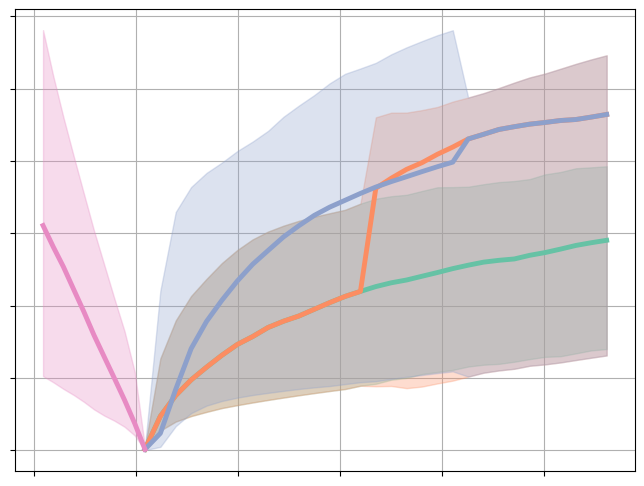

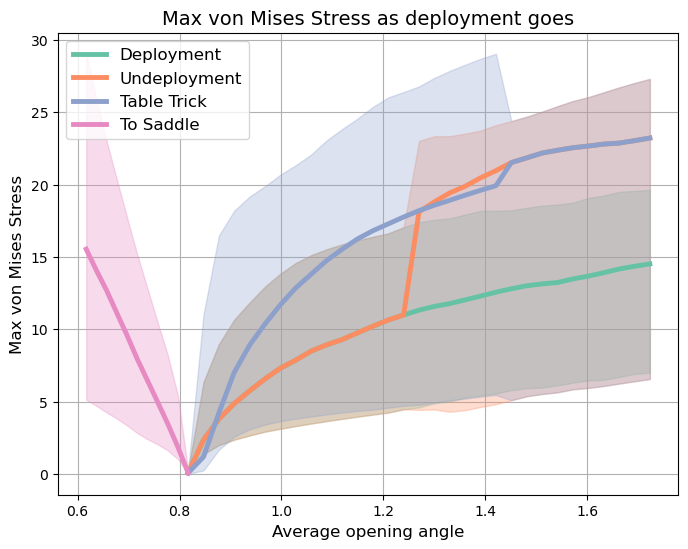

In [32]:
listShow = [False, True]

listFnStresses = [
    os.path.join(pathToSave, "stresses.png"),
    os.path.join(pathToSave, "stressesNoText.png"),
]

for show, fn in zip(listShow, listFnStresses):
    CompareDeploymentStatistics(
        listDeployments, listNames=listNames, xlim=None, 
        minBounds=None, maxBounds=None, useMedian=True,
        filename=fn, showText=show, vmOnly=True
    )

## Energies

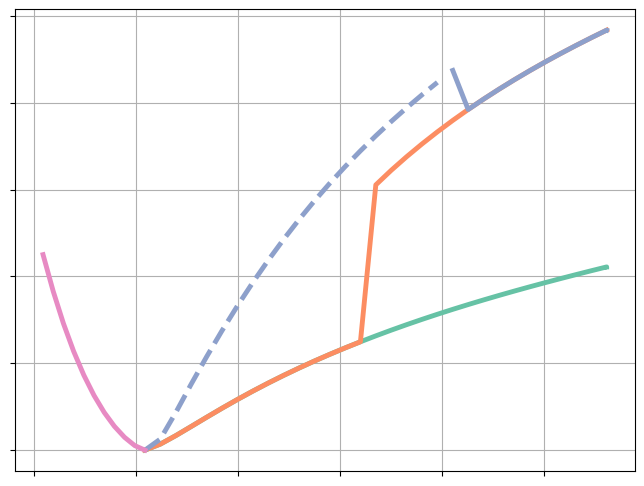

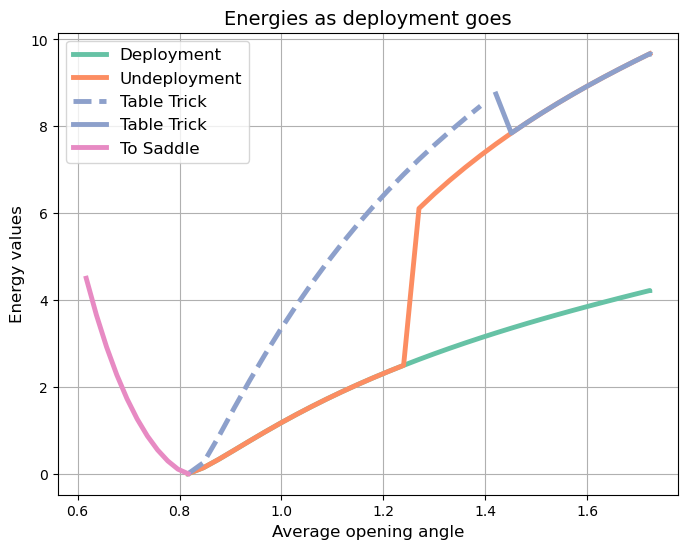

In [33]:
listShow = [False, True]

listFnEnergies = [
    os.path.join(pathToSave, "energiesDep.png"),
    os.path.join(pathToSave, "energiesDepNoText.png"),
]

for show, fn in zip(listShow, listFnEnergies):
    CompareDeploymentQuantities(
        listDeployments, listNames=listNames, xlimEnergies=None, ylimEnergies=None, 
        xlimTorque=None, ylimTorque=None, 
        showTorque=False, showAnnotations=False, showText=show, filename=fn
    )